In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import torch
import sys
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import sys
sys.path.insert(0, '/home/ph3641/WDM/')
import clustering
import util_LR
import FRLC_LRDist

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'On device: {device}')
dtype = torch.float64

daniocell_dir = '/scratch/gpfs/ph3641/zebrafish/daniocell.h5ad'
adata_daniocell = sc.read_h5ad(daniocell_dir)

stages = np.unique(adata_daniocell.obs['hpf'].values)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'On device: {device}')
dtype = torch.float64

filehandle_zf = '/scratch/gpfs/ph3641/zebrafish/'

zf_list = ['zf3', 'zf5', 'zf10', 'zf12', 'zf18', 'zf24']
zf_names = zf_list
filehandles_zf = [filehandle_zf + 'pair' + str(k) + '/' for k in range(len(zf_list))]
N = len(filehandles_zf)

spatial_list = []
exclude_rows = [1099, None, None, 325, None, None]

for i in range(len(zf_list)):
    file_spatial = filehandles_zf[i] + zf_names[i] +'_spatial.npy'
    if i == len(zf_list) - 1:
        file_spatial = filehandles_zf[i-1] + zf_names[i] +'_spatial.npy'
    spatial = np.load(file_spatial)
    nidx = exclude_rows[i]
    if nidx is not None:
        spatial = np.concatenate((spatial[:nidx,:], spatial[nidx+1:,:]))
    spatial_list.append(spatial)


def load_mats(save_dir, s1_name, s2_name, device, z=None, c=100, nidx_1=None, nidx_2=None):
    # Load costs
    A = np.load(save_dir + 'SA.npy')
    B = np.load(save_dir + 'SB.npy')
    
    ys = torch.from_numpy(np.load(save_dir + s1_name + f'_feature.npy')).type(torch.DoubleTensor).to(device)
    ys2 = torch.from_numpy(np.load(save_dir + s2_name + f'_feature.npy')).type(torch.DoubleTensor).to(device)
    
    if nidx_1 is not None:
        ys = torch.cat((ys[:nidx_1,:], ys[nidx_1+1:,:]))
    if nidx_2 is not None:
        ys2 = torch.cat((ys2[:nidx_2,:], ys2[nidx_2+1:,:]))
    
    C = torch.cdist(ys, ys2).type(torch.DoubleTensor).to(device)
    
    norm1 = c
    norm2 = A.max()*c
    norm3 = B.max()*c
    
    if z is None:
        # No low-rank factorization applied to the distance matrix
        A = torch.from_numpy(A).to(device)
        B = torch.from_numpy(B).to(device)
        C_factors = (C/ (norm1), torch.eye(C.shape[1]).type(torch.DoubleTensor).to(device))
        A_factors = (A/ (norm2), torch.eye(A.shape[1]).type(torch.DoubleTensor).to(device))
        B_factors = (B/ (norm3), torch.eye(B.shape[1]).type(torch.DoubleTensor).to(device))

    else:
        # Distance matrix factored using SVD
        u, s, v = torch.svd(C)
        print('C done')
        V_C,U_C = torch.mm(u[:,:z], torch.diag(s[:z])), v[:,:z].mT
        u, s, v = torch.svd(torch.from_numpy(A).to(device))
        print('A done')
        V1_A,V1_B = torch.mm(u[:,:z], torch.diag(s[:z])), v[:,:z].mT
        u, s, v = torch.svd(torch.from_numpy(B).to(device))
        print('B done')
        V2_A,V2_B = torch.mm(u[:,:z], torch.diag(s[:z])), v[:,:z].mT
        C_factors, A_factors, B_factors = ((V_C.type(torch.DoubleTensor).to(device)/norm1, U_C.type(torch.DoubleTensor).to(device)/norm1), \
                                       (V1_A.type(torch.DoubleTensor).to(device)/norm2, V1_B.type(torch.DoubleTensor).to(device)/norm2), \
                                       (V2_A.type(torch.DoubleTensor).to(device)/norm3, V2_B.type(torch.DoubleTensor).to(device)/norm3))
    
    return C_factors, A_factors, B_factors


On device: cuda
On device: cuda


In [2]:

N = len(filehandles_zf)
Qs = [None]*(N-1)
Rs = [None]*(N-1)

key = 'bin_annotation'

labels = []

for i in range(N-2, -1, -1):

    s1_name = zf_names[i]
    s2_name = zf_names[i+1]
    
    print(f'Slice pair {i}, aligning {s1_name} to {s2_name}')
    
    adata_pair = sc.read_h5ad(filehandle_zf + f'pair{i}/' + s1_name + '_' + s2_name + '.h5ad')
    
    adata1 = adata_pair[adata_pair.obs['timepoint'] == 1]
    sc.pp.normalize_total(adata1)
    sc.pp.log1p(adata1)
    
    adata2 = adata_pair[adata_pair.obs['timepoint'] == 2]
    sc.pp.normalize_total(adata2)
    sc.pp.log1p(adata2)
    
    encoder1 = OneHotEncoder(sparse_output=False)
    ys_onehot1 = encoder1.fit_transform(adata1.obs[key].values.reshape(-1, 1))
    _Q = ys_onehot1 / np.sum(ys_onehot1)
    
    encoder2 = OneHotEncoder(sparse_output=False)
    ys_onehot2 = encoder2.fit_transform(adata2.obs[key].values.reshape(-1, 1))
    _R = ys_onehot2 / np.sum(ys_onehot2)

    labels.append(list(encoder2.categories_[0]))
    
    if i == 0:
        labels.append(list(encoder1.categories_[0]))
    
    _Q, _R = torch.from_numpy(_Q).to(device).float(), torch.from_numpy(_R).to(device).float()

    # Filter rows
    nidx_1, nidx_2 = exclude_rows[i], exclude_rows[i+1]
    if nidx_1 is not None:
        _Q = torch.cat((_Q[:nidx_1,:], _Q[nidx_1+1:,:]))
    if nidx_2 is not None:
        _R = torch.cat((_R[:nidx_2,:], _R[nidx_2+1:,:]))
        
    Qs[i], Rs[i] = _Q, _R

Slice pair 4, aligning zf18 to zf24


/home/ph3641/.conda/envs/peterenv2/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/ph3641/.conda/envs/peterenv2/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Slice pair 3, aligning zf12 to zf18


/home/ph3641/.conda/envs/peterenv2/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/ph3641/.conda/envs/peterenv2/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Slice pair 2, aligning zf10 to zf12


/home/ph3641/.conda/envs/peterenv2/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/ph3641/.conda/envs/peterenv2/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Slice pair 1, aligning zf5 to zf10
Slice pair 0, aligning zf3 to zf5


/home/ph3641/.conda/envs/peterenv2/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/ph3641/.conda/envs/peterenv2/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/ph3641/.conda/envs/peterenv2/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/ph3641/.conda/envs/peterenv2/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [49]:
ranks = [(3,7),(7,7),(7,11),(11,14),(14,19)]
exclude_rows = [1099, None, None, 325, None, None]

i=2

s1_name = zf_names[i]
s2_name = zf_names[i+1]
s3_name = zf_names[i+2]
print(f'Aligning slices {s1_name} to {s2_name} to {s3_name}')

r1, r2 = ranks[i]
r2, r3 = ranks[i+1]
nidx_1, nidx_2, nidx_3 = exclude_rows[i], exclude_rows[i+1], exclude_rows[i+2]

filehandle_pair = filehandle_zf + 'pair' + str(i) + '/'
save_dir = filehandle_pair
C_factors12, A_factors11, A_factors22 = load_mats(save_dir, s1_name, s2_name, \
                                                device, z=400, c=100, nidx_1=nidx_1, nidx_2=nidx_2)

filehandle_pair = filehandle_zf + 'pair' + str(i+1) + '/'
save_dir = filehandle_pair
C_factors23, A_factors22, A_factors33 = load_mats(save_dir, s2_name, s3_name, \
                                                device, z=400, c=100, nidx_1=nidx_2, nidx_2=nidx_3)

c = max(torch.max(C_factors12[0] @ C_factors12[1]), torch.max( C_factors23[0] @ C_factors23[1]))
c = max(c, 1/c)

C_factors12 = (C_factors12[0]/c, C_factors12[1]/c)
C_factors23 = (C_factors23[0]/c, C_factors23[1]/c)

Aligning slices zf10 to zf12 to zf18
C done
A done
B done
C done
A done
B done


Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 100
Iteration: 125
Iteration: 150
Iteration: 175
Initial Wasserstein cost: 2.6420545436958388e-09, Triplet cost: 2.4761073448398763e-07, (partial) GW-cost: -2.2272809687883218e-08, Total cost: 1.5056812053793306e-10
Final Wasserstein cost: 2.3781837985699116e-09, Triplet cost: 1.5194870953588064e-07, (partial) GW-cost: -2.7825601773830278e-08, Total cost: -6.421947586701073e-10


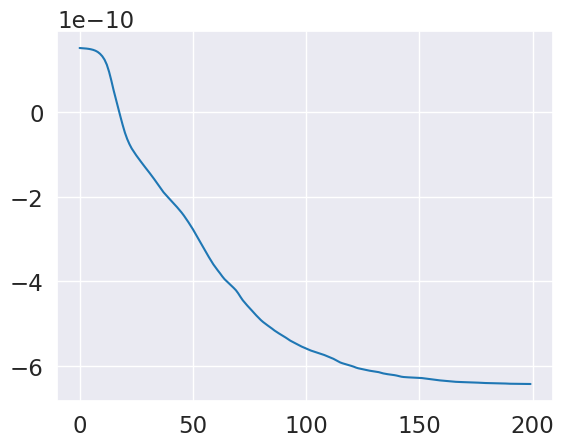

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 100
Iteration: 125
Iteration: 150
Iteration: 175
Initial Wasserstein cost: 2.951871926599778e-09, Triplet cost: 1.3065674249479424e-07, (partial) GW-cost: -2.112417600928765e-08, Total cost: 5.442671330110351e-10
Final Wasserstein cost: 2.690022038658328e-09, Triplet cost: 9.401739575574836e-08, (partial) GW-cost: -2.3456852209064456e-08, Total cost: 7.533461388604949e-11


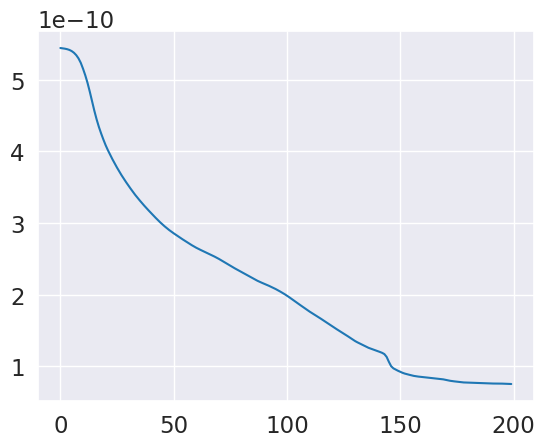

Ranks: r1 7, r2 11, r3 14
Iteration: 0
tensor(7.2529e-05, device='cuda:0', dtype=torch.float64)
tensor(-8.1826e-08, device='cuda:0', dtype=torch.float64)
tensor(7.2876e-05, device='cuda:0', dtype=torch.float64)
tensor(8.4743e-07, device='cuda:0', dtype=torch.float64)
tensor(7.3226e-05, device='cuda:0', dtype=torch.float64)
tensor(1.7990e-06, device='cuda:0', dtype=torch.float64)
tensor(7.3553e-05, device='cuda:0', dtype=torch.float64)
tensor(2.6589e-06, device='cuda:0', dtype=torch.float64)
tensor(7.3828e-05, device='cuda:0', dtype=torch.float64)
tensor(3.4738e-06, device='cuda:0', dtype=torch.float64)
tensor(7.4101e-05, device='cuda:0', dtype=torch.float64)
tensor(4.3002e-06, device='cuda:0', dtype=torch.float64)
tensor(7.4564e-05, device='cuda:0', dtype=torch.float64)
tensor(5.3592e-06, device='cuda:0', dtype=torch.float64)
tensor(7.5056e-05, device='cuda:0', dtype=torch.float64)
tensor(6.4386e-06, device='cuda:0', dtype=torch.float64)
tensor(7.5449e-05, device='cuda:0', dtype=torch.

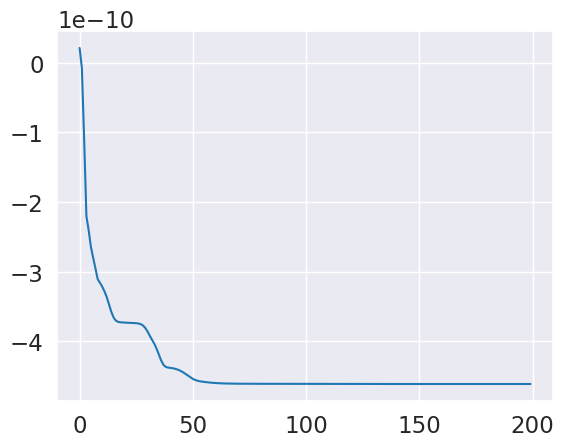

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 100
Iteration: 125
Iteration: 150
Iteration: 175
Initial Wasserstein cost: 2.865723232022842e-09, Triplet cost: 1.0140717053410643e-07, (partial) GW-cost: -2.1674515687844402e-08, Total cost: 4.116993400361173e-10
Final Wasserstein cost: 2.7238615645823143e-09, Triplet cost: 8.318697424642468e-08, (partial) GW-cost: -2.4445936659972344e-08, Total cost: 6.881742126848215e-12


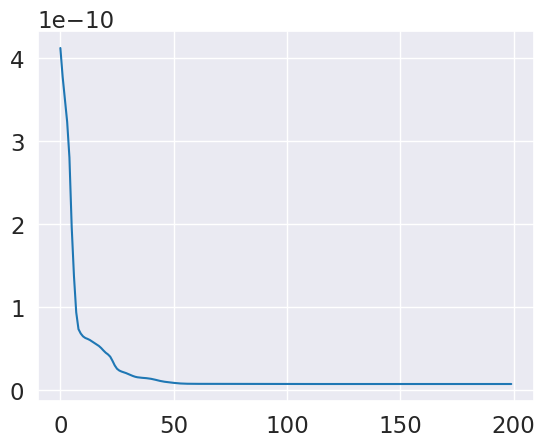

In [50]:
import importlib
import WassersteinDiffMap
importlib.reload(WassersteinDiffMap)

gamma=30
tau_out=1
tau_in=1e-6 #5
alpha = 0.1 #0.8 #0.98
beta = 0.0

ranks = [(7,11),(11,14)]
C_factors_sequence, A_factors_sequence = (C_factors12, C_factors23), (A_factors11, A_factors22, A_factors33)

WDM = WassersteinDiffMap.WassersteinDifferentiationMapping(ranks, tau_in = tau_in, tau_out=tau_out, \
                  gamma=gamma, max_iter=200, min_iter=200, device=device, dtype=torch.float64, \
                 printCost=True, returnFull=False, alpha=alpha, beta=beta, \
                  initialization='Full', init_args = None)

WDM.gamma_smoothing(C_factors_sequence, A_factors_sequence)

torch.Size([1036, 7])
torch.Size([2080, 11])
torch.Size([3048, 14])
2080
3048
2080
3048
Number of clusters in slice 1: 11
Number of clusters in slice 2: 14
Number of clusters in common: 11
Number of clusters total: 14


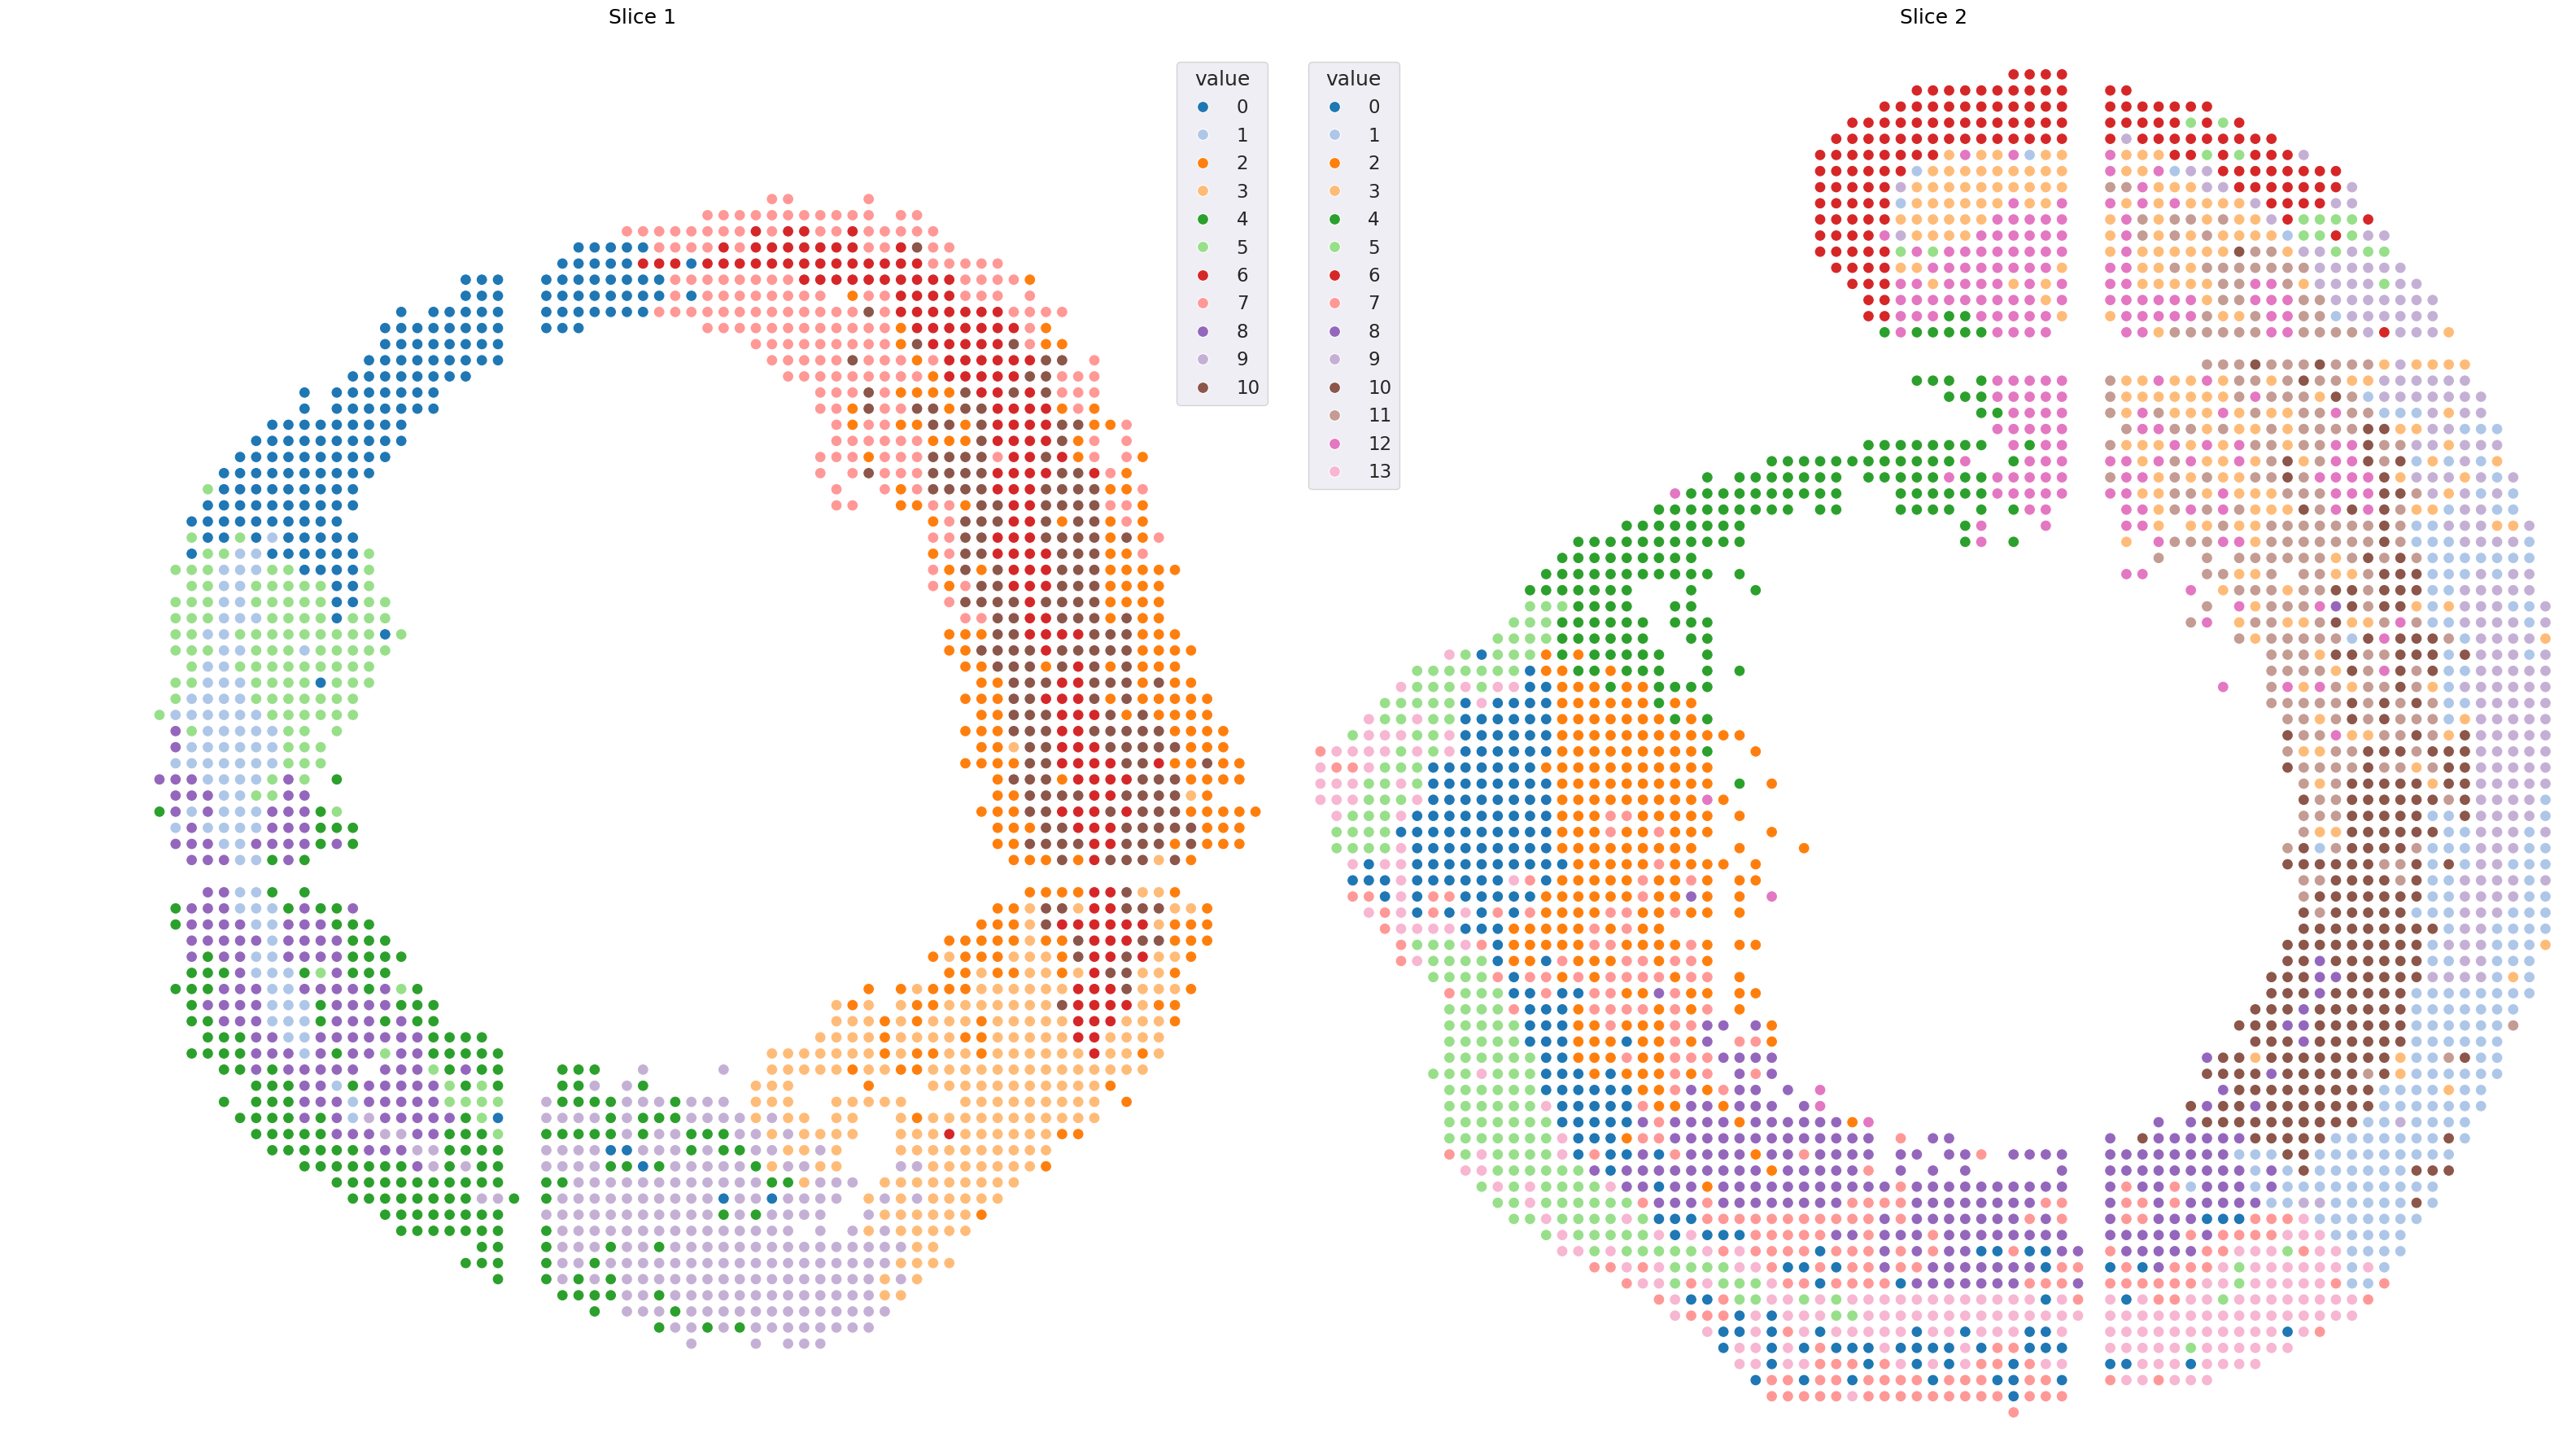

Progress: 0/3048
Number of clusters in slice 1: 13
Number of clusters in slice 2: 11
Number of clusters in common: 11
Number of clusters total: 13


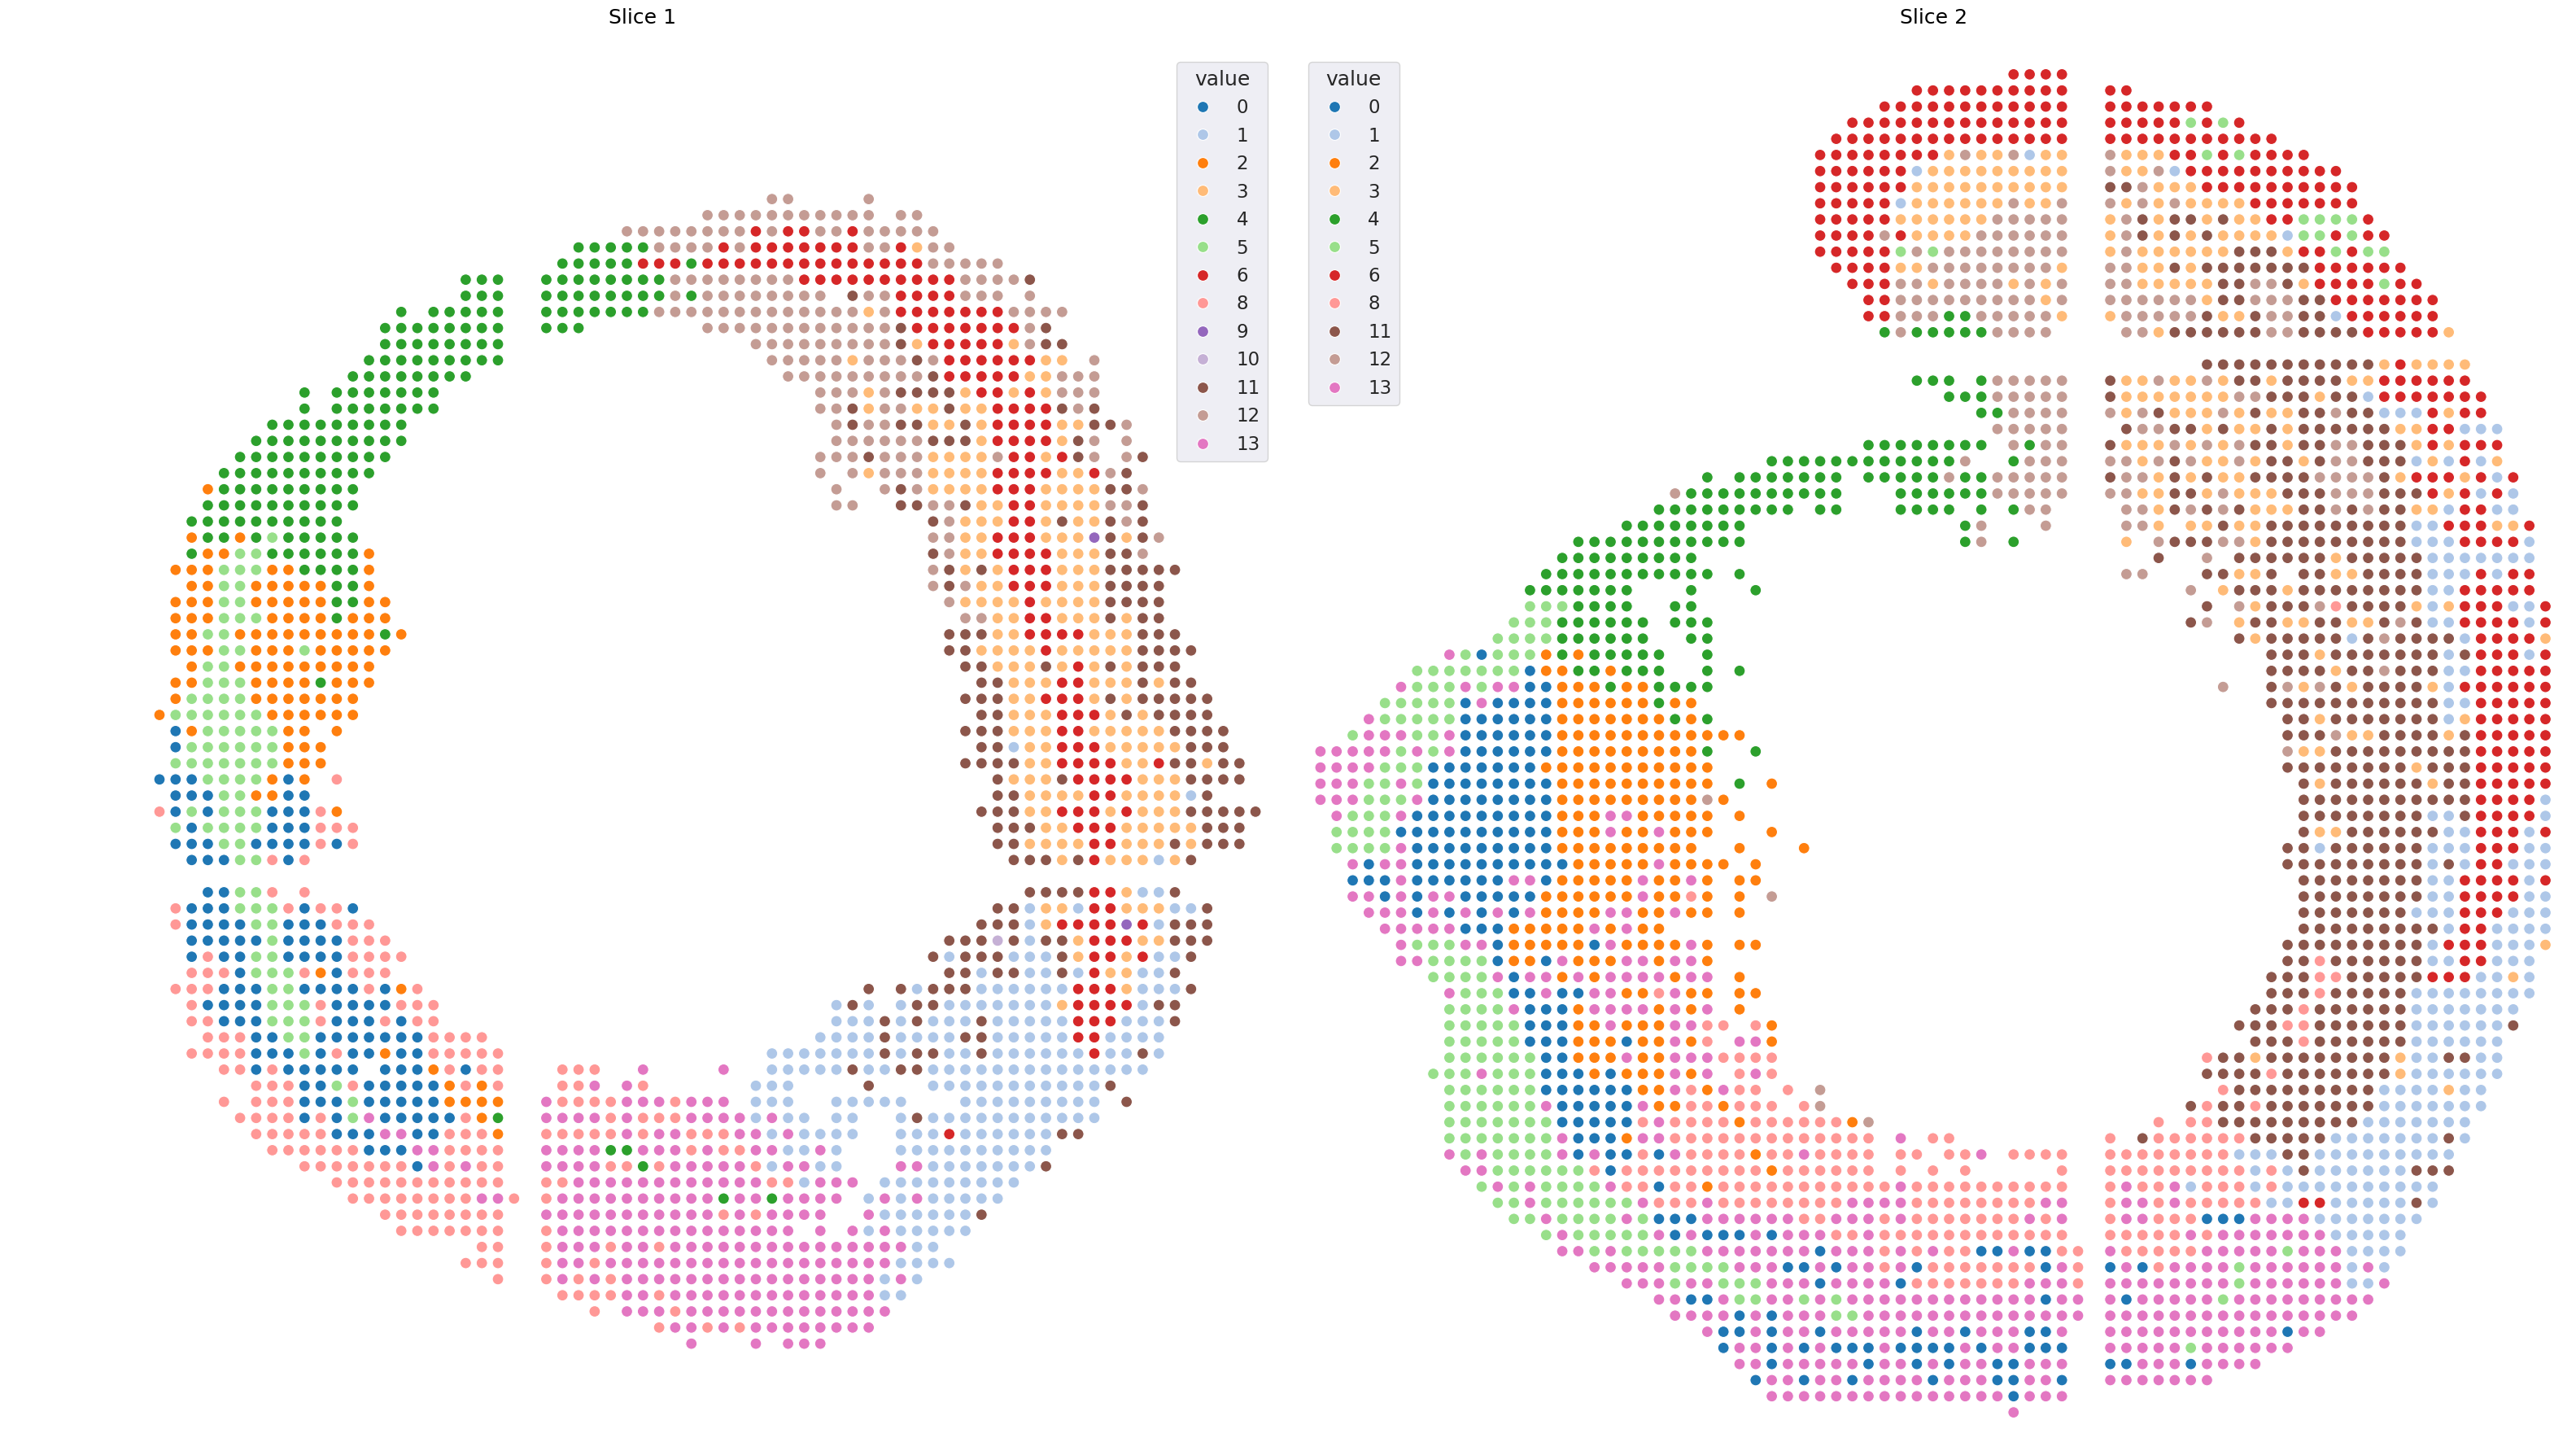

In [51]:
Q0, Q1, Q2 = WDM.Q_gammas[0], WDM.Q_gammas[1], WDM.Q_gammas[2]

print(Q0.shape)
print(Q1.shape)
print(Q2.shape)

spatial_list2 = []
for i in range(len(zf_list)):
    file_spatial = filehandles_zf[i] + zf_names[i] +'_spatial.npy'
    if i == len(zf_list) - 1:
        file_spatial = filehandles_zf[i-1] + zf_names[i] +'_spatial.npy'
    spatial = np.load(file_spatial)
    spatial_list2.append(spatial)

i = 2
xs = torch.from_numpy(spatial_list[i+1]).to(device)
xs2 = torch.from_numpy(spatial_list2[i+2]).to(device)

ml_labels_W, ml_labels_H = clustering.max_likelihood_clustering(Q1.cpu().numpy(), Q2.cpu().numpy())

print(len(xs))
print(len(xs2))
print(len(ml_labels_W))
print(len(ml_labels_H))

clustering.plot_cluster_pair(xs,
                            xs2,
                                 ml_labels_W,
                                 ml_labels_H, dotsize=100)

T12 = WDM.T_gammas[1]
ml_labels_W, ml_labels_H = clustering.ancestral_clustering(Q1.cpu().numpy(), Q2.cpu().numpy(),T12.cpu().numpy(), full_P=False)
clustering.plot_cluster_pair(xs,
                            xs2,
                                 ml_labels_W,
                                 ml_labels_H, dotsize=100)

# Compare to case where clusters at $t_{1}, t_{3}$ fixed from annotations

In [47]:
# Initialize as arguments
init_args = (Qs[i].type(torch.DoubleTensor).to(device), Rs[i+1].type(torch.DoubleTensor).to(device))
Q1, R2 = init_args

# Learn smoothed co-clustering Q_t
Q_t, T_tm1t, T_ttp1 = FRLC_LRDist.FRLC_LR_opt_multimarginal(C_factors12, \
                                              A_factors11, \
                                             A_factors22, \
                                                C_factors23, \
                                              A_factors22, \
                                             A_factors33,  \
                                            r=r2, max_iter=120, device=device, \
                                             returnFull=False, alpha=alpha, beta=beta, \
                                            min_iter = 100, initialization='Full', tau_out=tau_out, tau_in=tau_in, gamma=gamma, \
                                            dtype=torch.float64, init_args=init_args)
gQ = Q_t.T @ torch.ones(Q_t.shape[0]).type(torch.DoubleTensor).to(device)
print(gQ)

Ranks: r1 7, r2 11, r3 14
Iteration: 0
tensor(7.2500e-05, device='cuda:0', dtype=torch.float64)
tensor(-1.9118e-08, device='cuda:0', dtype=torch.float64)
tensor(7.2696e-05, device='cuda:0', dtype=torch.float64)
tensor(9.9198e-07, device='cuda:0', dtype=torch.float64)
tensor(7.2913e-05, device='cuda:0', dtype=torch.float64)
tensor(1.9496e-06, device='cuda:0', dtype=torch.float64)
tensor(7.3345e-05, device='cuda:0', dtype=torch.float64)
tensor(2.7966e-06, device='cuda:0', dtype=torch.float64)
tensor(7.3834e-05, device='cuda:0', dtype=torch.float64)
tensor(3.6108e-06, device='cuda:0', dtype=torch.float64)
tensor(7.4219e-05, device='cuda:0', dtype=torch.float64)
tensor(4.1805e-06, device='cuda:0', dtype=torch.float64)
tensor(7.4834e-05, device='cuda:0', dtype=torch.float64)
tensor(4.5409e-06, device='cuda:0', dtype=torch.float64)
tensor(7.5771e-05, device='cuda:0', dtype=torch.float64)
tensor(4.8686e-06, device='cuda:0', dtype=torch.float64)
tensor(7.6326e-05, device='cuda:0', dtype=torch.

In [ ]:
spatial_list2 = []
for i in range(len(zf_list)):
    file_spatial = filehandles_zf[i] + zf_names[i] +'_spatial.npy'
    if i == len(zf_list) - 1:
        file_spatial = filehandles_zf[i-1] + zf_names[i] +'_spatial.npy'
    spatial = np.load(file_spatial)
    spatial_list2.append(spatial)

i = 3
xs = torch.from_numpy(spatial_list[i+1]).to(device)
xs2 = torch.from_numpy(spatial_list2[i+2]).to(device)

ml_labels_W, ml_labels_H = clustering.max_likelihood_clustering(Q_t.cpu().numpy(), R2.cpu().numpy())
print(xs.shape)
print(xs2.shape)
print(len(ml_labels_W))
print(len(ml_labels_H))

clustering.plot_cluster_pair(xs,
                            xs2,
                                 ml_labels_W,
                                 ml_labels_H, dotsize=100)

np.save('wasserstein_joint_ML.npy', np.array(ml_labels_W))

In [ ]:
ml_labels_W, ml_labels_H = clustering.ancestral_clustering(Q_t.cpu().numpy(),R2.cpu().numpy(),T_ttp1.cpu().numpy(), full_P=False)
clustering.plot_cluster_pair(xs,
                            xs2,
                                 ml_labels_W,
                                 ml_labels_H, dotsize=100)

np.save('wasserstein_joint.npy', np.array(ml_labels_W))

In [ ]:
xs0 = torch.from_numpy(spatial_list[i]).to(device)
ml_labels_W, ml_labels_H = clustering.ancestral_clustering(Q1.cpu().numpy(),Q_t.cpu().numpy(),T_tm1t.cpu().numpy(), full_P=False)
clustering.plot_cluster_pair(xs0,
                            xs,
                                 ml_labels_W,
                                 ml_labels_H, dotsize=100)

In [ ]:
init_args = (None, R2, None)

Qb,Rb,Tb, errs = DeSTOT_LRDist.DeSTOT_LR_opt(C_factors23, \
                                              A_factors22, \
                                             A_factors33, \
                                          a=None, b=None, \
                                          r=r2, r2=r3, max_iter= 220, device=device, \
                                         returnFull=False, alpha=alpha, beta=beta, \
                                        min_iter = 200, initialization='Full', tau_out=tau_out, tau_in=tau_in, gamma=gamma, \
                                        dtype=torch.float64, updateR = False, updateQ = True, updateT = True, init_args=init_args)
gQ = Qb.T @ torch.ones(Qb.shape[0]).type(torch.DoubleTensor).to(device)
print(gQ)

In [ ]:
ml_labels_W, ml_labels_H = clustering.ancestral_clustering(Qb.cpu().numpy(),Rb.cpu().numpy(),Tb.cpu().numpy(), full_P=False)
clustering.plot_cluster_pair(xs,
                            xs2,
                                 ml_labels_W,
                                 ml_labels_H, dotsize=100)
np.save('wasserstein_backward.npy', np.array(ml_labels_W))